This file performs linear regression, regularized linear regression, linear regression with polynomial features, and regularized linear regression with polynomial features.

In [1]:
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Import training and test sets
data_train = pd.read_csv('../data/data_train.csv')
data_test = pd.read_csv('../data/data_test.csv')

# Select variables
y_train = data_train['SalePrice']
x_train = data_train.drop(['SalePrice'], axis=1)

y_test = data_test['SalePrice']
x_test = data_test.drop(['SalePrice'], axis=1)

# Find continuous features/columns
cont_cols = []
for col in x_train.columns:
    if data_train[col].value_counts().index.to_list() not in [[0, 1], [1, 0], [1], [0]]:
        cont_cols.append(col)

Min value of cluster 1 is:  294000
Max value of cluster 1 is:  755000
Min value of cluster 2 is:  34900
Max value of cluster 2 is:  174000
Min value of cluster 3 is:  174500
Max value of cluster 3 is:  293077


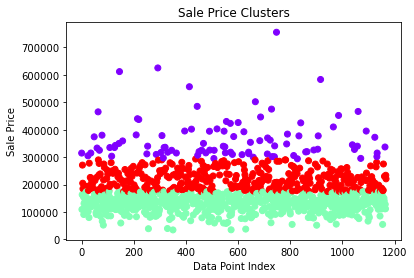

In [3]:
# Group homes into three clusters: low-priced, medium-priced, and high-priced
# We will use these groups to examine the fairness of our models
cluster = KMeans(n_clusters=3, random_state=3)
cluster.fit(y_train.values.reshape(-1,1))

# Print cluster thresholds
for i in range(3):
    print('Min value of cluster', i+1, 'is: ', y_train[cluster.labels_==i].min())
    print('Max value of cluster', i+1, 'is: ', y_train[cluster.labels_==i].max())

# Plot clusters
colormap = cm.rainbow(np.linspace(0, 1, len(cluster.cluster_centers_)))
plt.scatter(y_train.index, y_train, c=colormap[cluster.labels_])
plt.title('Sale Price Clusters')
plt.ylabel('Sale Price')
plt.xlabel('Data Point Index')
plt.show()
    
# Extract cluster thresholds
low_cluster_threshold = y_train.max()
high_cluster_threshold = y_train.min()
for i in range(3):
    cluster_threshold = y_train[cluster.labels_==i].max()
    if cluster_threshold < low_cluster_threshold:
        low_cluster_threshold = cluster_threshold
    if cluster_threshold > high_cluster_threshold and cluster_threshold < y_train.max():
        high_cluster_threshold = cluster_threshold

In [4]:
# Load function for computing model evaluation metrics and creating plots
def metrics_and_plots(y_test, y_test_hat):
    '''
    Compute and print model evaluation metrics.
    '''
    mae = mean_absolute_error(y_test, y_test_hat)
    mse = mean_squared_error(y_test, y_test_hat)
    r2 = r2_score(y_test, y_test_hat)
    print("""\n Evaluation metrics: \n
             MAE: {} \n
             MSE: {} \n
             R2: {} \n""".format(mae, mse, r2))

    # Fairness graph
    error = y_test - y_test_hat
    low_error = error[y_test <= low_cluster_threshold]
    low_undervalued = low_error[low_error < 0].count() / low_error.count()
    low_overvalued = low_error[low_error > 0].count() / low_error.count()
    med_error = error[(low_cluster_threshold < y_test) & (y_test <= high_cluster_threshold)]
    med_undervalued = med_error[med_error < 0].count() / med_error.count()
    med_overvalued = med_error[med_error > 0].count() / med_error.count()
    high_error = error[high_cluster_threshold < y_test]
    high_undervalued = high_error[high_error < 0].count() / high_error.count()
    high_overvalued = high_error[high_error > 0].count() / high_error.count()
    fairness_data = pd.DataFrame({'Percentage' : [low_undervalued, low_overvalued, med_undervalued, med_overvalued,
                                                  high_undervalued, high_overvalued],
                                  'Valuation Error' : ['Under-valued', 'Over-valued', 'Under-valued', 'Over-valued',
                                                       'Under-valued','Over-valued'],
                                  'Cluster': ['Low-Priced Homes', 'Low-Priced Homes', 'Medium-Priced Homes',
                                              'Medium-Priced Homes', 'High-Priced Homes', 'High-Priced Homes']})
    plot = sns.barplot(x='Cluster', y='Percentage', hue='Valuation Error', data=fairness_data)
    plot.legend_.set_title('')
    plot.set_title('Valuation by Home Price')
    plot.set_xlabel('')
    plt.ylim((0, 1))
    plt.show();
    
    # Plot actual vs. predicted
    plt.figure(figsize=(16,6))
    plot = sns.scatterplot(x=y_test, y=y_test_hat)
    plot.set(xlabel='Actual Sale Price', ylabel='Predicted Sale Price')
    plot.set_title('Predicted Sale Price vs. Actual Sale Price')
    plt.plot(np.array([65000.,450000.]), np.array([65000.,450000.]), color='red', alpha=0.4, linewidth=3)
    plt.show()

  params  mean_test_neg_mean_squared_error  mean_test_neg_mean_absolute_error  \
0     {}                     -4.010915e+29                      -3.870175e+13   

   mean_test_r2  std_test_neg_mean_absolute_error  
0 -6.206778e+19                      6.355756e+13  
       Condition2_PosN      PoolQC_Ex  GarageCond_Ex     PoolQC_Fa  \
coeff   -471147.610693 -190217.177712   -95139.74659 -82909.796573   

       MiscFeature_Gar2  ...  SaleType_CWD  RoofMatl_Metal  RoofStyle_Shed  \
coeff     -81536.733054  ...  58661.437527    63703.158972    75311.483592   

       GarageQual_Ex  RoofMatl_Membran  
coeff   81944.398326      90530.911988  

[1 rows x 364 columns]

 Evaluation metrics: 

             MAE: 24133.357939789003 

             MSE: 3886295539.150717 

             R2: 0.43724587713201724 



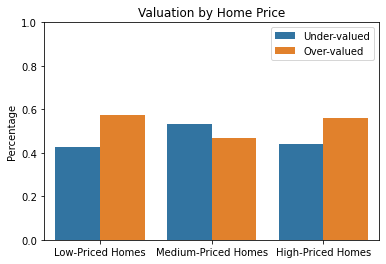

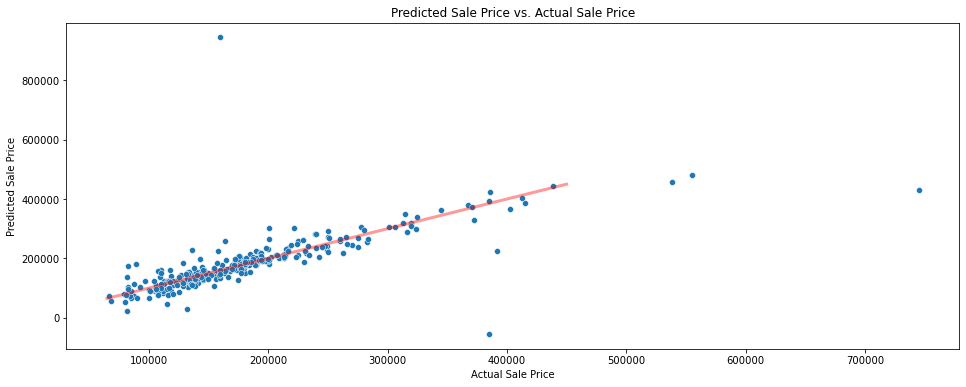

In [23]:
pd.set_option('display.max_columns', 10)

# Fit a basic linear regression model
ct = ColumnTransformer([
        ('scaler', StandardScaler(), cont_cols)
    ], remainder='passthrough')
pipeline = Pipeline([
    ('norm', ct),
    ('regr', linear_model.LinearRegression()),
])
params = {}

gs = GridSearchCV(estimator=pipeline, 
                  param_grid=params, 
                  cv=5,
                  scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                  refit='neg_mean_absolute_error')
gs.fit(x_train, y_train)

# Output results
results = pd.DataFrame(gs.cv_results_)
results = results.sort_values(by=['mean_test_neg_mean_squared_error'])
print(results[['params', 'mean_test_neg_mean_squared_error', 'mean_test_neg_mean_absolute_error', 'mean_test_r2',
               'std_test_neg_mean_absolute_error']])

# Print coefficients
coeffs = pd.DataFrame(data=np.reshape(gs.best_estimator_['regr'].coef_, (1,-1)), columns=x_train.columns, index=['coeff'] )
print(coeffs.sort_values(by='coeff', axis=1))

# Predict housing values for the test set
y_test_hat = gs.predict(x_test)

# Compute model evaluation metrics
metrics_and_plots(y_test, y_test_hat)

                     params  mean_test_neg_mean_squared_error  \
13  {'Lasso__alpha': 10000}                     -1.364318e+09   
12   {'Lasso__alpha': 5000}                     -1.140478e+09   
0     {'Lasso__alpha': 0.1}                     -1.049980e+09   
1       {'Lasso__alpha': 1}                     -9.997006e+08   
11   {'Lasso__alpha': 1000}                     -8.853606e+08   
2      {'Lasso__alpha': 10}                     -8.576947e+08   
10    {'Lasso__alpha': 500}                     -8.504400e+08   
3      {'Lasso__alpha': 30}                     -8.065097e+08   
4      {'Lasso__alpha': 31}                     -8.060977e+08   
5      {'Lasso__alpha': 32}                     -8.057033e+08   
9     {'Lasso__alpha': 151}                     -7.939583e+08   
8     {'Lasso__alpha': 150}                     -7.938872e+08   
7     {'Lasso__alpha': 149}                     -7.938224e+08   
6     {'Lasso__alpha': 100}                     -7.904868e+08   

    mean_test_neg_mean_a

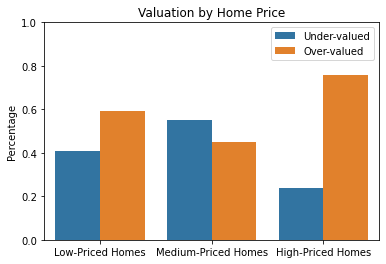

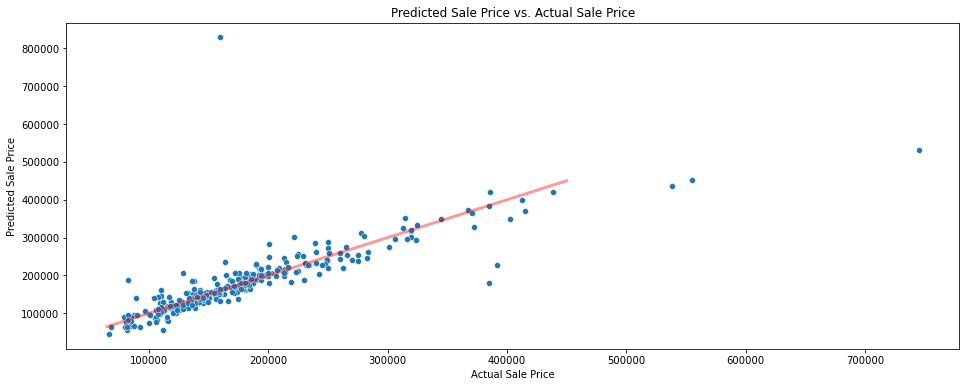

                     params  mean_test_neg_mean_squared_error  \
13  {'Ridge__alpha': 10000}                     -2.835574e+09   
12   {'Ridge__alpha': 5000}                     -1.982540e+09   
11   {'Ridge__alpha': 1000}                     -1.079767e+09   
10    {'Ridge__alpha': 500}                     -9.530582e+08   
0     {'Ridge__alpha': 0.1}                     -9.495428e+08   
1       {'Ridge__alpha': 1}                     -8.586175e+08   
9     {'Ridge__alpha': 151}                     -8.474705e+08   
8     {'Ridge__alpha': 150}                     -8.471225e+08   
7     {'Ridge__alpha': 149}                     -8.467741e+08   
6     {'Ridge__alpha': 100}                     -8.293585e+08   
2      {'Ridge__alpha': 10}                     -8.139960e+08   
5      {'Ridge__alpha': 32}                     -8.075562e+08   
4      {'Ridge__alpha': 31}                     -8.074123e+08   
3      {'Ridge__alpha': 30}                     -8.072859e+08   

    mean_test_neg_mean_a

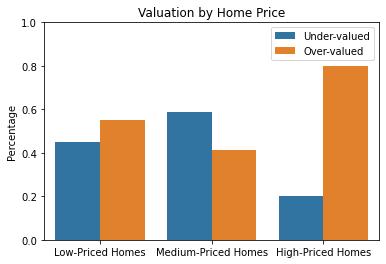

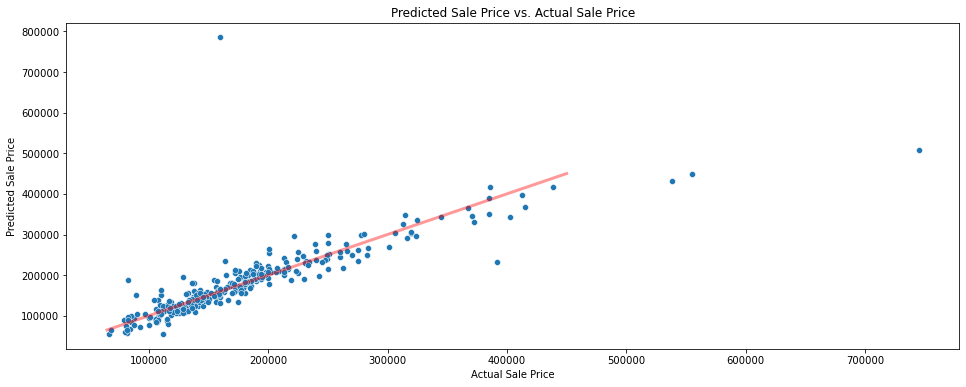

                           params  mean_test_neg_mean_squared_error  \
13  {'Elastic Net__alpha': 10000}                     -6.158873e+09   
12   {'Elastic Net__alpha': 5000}                     -6.143102e+09   
11   {'Elastic Net__alpha': 1000}                     -6.019006e+09   
10    {'Elastic Net__alpha': 500}                     -5.870360e+09   
9     {'Elastic Net__alpha': 151}                     -5.266532e+09   
8     {'Elastic Net__alpha': 150}                     -5.261352e+09   
7     {'Elastic Net__alpha': 149}                     -5.256112e+09   
6     {'Elastic Net__alpha': 100}                     -4.897527e+09   
5      {'Elastic Net__alpha': 32}                     -3.419163e+09   
4      {'Elastic Net__alpha': 31}                     -3.372502e+09   
3      {'Elastic Net__alpha': 30}                     -3.324320e+09   
2      {'Elastic Net__alpha': 10}                     -1.915356e+09   
1       {'Elastic Net__alpha': 1}                     -9.441569e+08   
0     

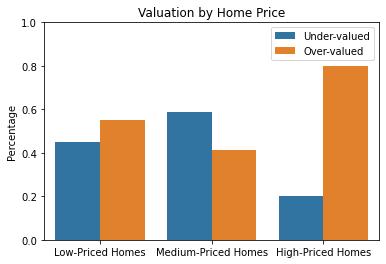

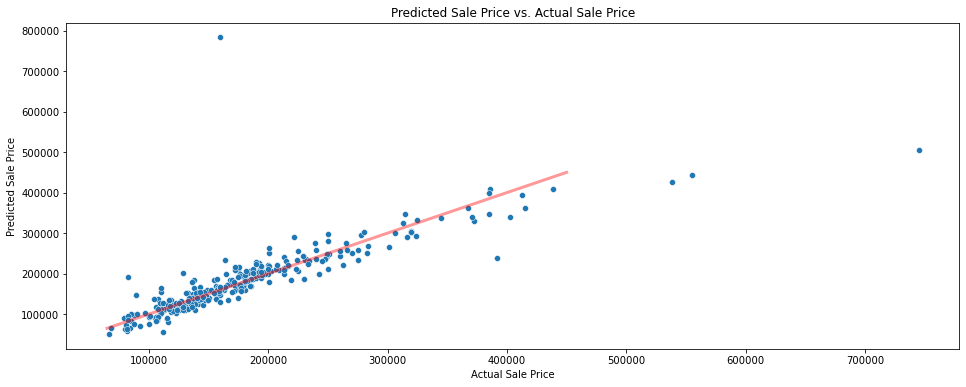

In [5]:
# Fit a regularized linear regression model
models = [('Lasso', linear_model.Lasso(max_iter=100000)),
           ('Ridge', linear_model.Ridge(max_iter=100000)),
           ('Elastic Net', linear_model.ElasticNet(max_iter=100000))]

for model_name, model in models:
    params = {model_name + '__alpha' : (0.1,1,10,30,31,32,100,149,150,151,500,1000,5000,10000)}
    ct = ColumnTransformer([
        ('scaler', StandardScaler(), cont_cols)
    ], remainder='passthrough')
    pipeline = Pipeline([
        ('norm', ct),
        (model_name, model)
    ])
    gs = GridSearchCV(estimator=pipeline, 
                      param_grid=params, 
                      cv=5,
                      scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                      refit='neg_mean_absolute_error')
    gs.fit(x_train, y_train)
    
    # Output results
    results = pd.DataFrame(gs.cv_results_)
    results = results.sort_values(by=['mean_test_neg_mean_squared_error'])
    print(results[['params', 'mean_test_neg_mean_squared_error', 'mean_test_neg_mean_absolute_error', 'mean_test_r2',
                   'std_test_neg_mean_absolute_error']])
    
    # Output the alpha that gives the best fit for the model
    print("Best ", model_name, " model:")
    print(gs.best_params_)
    
    # Print coefficients
    coeffs = pd.DataFrame(data=np.reshape(gs.best_estimator_[model_name].coef_, (1,-1)), columns=x_train.columns,
                          index=['coeff'] )
    print(coeffs.sort_values(by='coeff', axis=1))
    if model_name == 'Lasso':
        lasso_coeffs = coeffs
        
    # Predict housing values for the test set using the best model
    y_test_hat = gs.predict(x_test)
    
    # Compute model evaluation metrics for the best model
    metrics_and_plots(y_test, y_test_hat)

In [6]:
# The next block fails due to inadequate memory if we keep all variables, so we instead drop variables
# based on the results of the models above.
# Above, the regularized linear models had lower MAE than the non-regularized linear model. The Elastic Net
# and Ridge models only dropped five variables, so we choose to drop the variables that have a coefficient
# of zero in the Lasso model.

cols_to_drop = lasso_coeffs.columns[(lasso_coeffs==0).iloc[0]].to_list()

x_train_trunc = x_train.copy(deep=True)
x_test_trunc = x_test.copy(deep=True)

x_train_trunc.drop(cols_to_drop, axis=1, inplace=True)
x_test_trunc.drop(cols_to_drop, axis=1, inplace=True)

cont_cols_trunc = []
for col in cont_cols:
    if col not in cols_to_drop:
        cont_cols_trunc.append(col)

  params  mean_test_neg_mean_squared_error  mean_test_neg_mean_absolute_error  \
0     {}                     -2.563795e+09                      -25033.268789   

   mean_test_r2  std_test_neg_mean_absolute_error  
0      0.591485                       3375.461001  
Best linear model with polynomial features:
{}
       WoodDeckSF HeatingQC_Ex  GarageYrBlt_2007.0 MoSold_2  \
coeff             -7018.475483                 -6939.370771   

       YearBuilt Fireplaces  MasVnrType_BrkFace BsmtQual_Ex  \
coeff          -6629.915661                    -6599.865514   

       MasVnrArea MoSold_2  GarageYrBlt_2003.0 YrSold_2009  \
coeff         -6110.758115                    -5948.675808   

       WalkScore SaleCondition_Abnorml  LotFrontage KitchenQual_Ex  \
coeff                     -5312.618761                -5295.424305   

       BsmtFinSF1 FireplaceQu_Gd  WoodDeckSF BsmtExposure_Gd  ...  \
coeff               -5276.480652                -5260.127923  ...   

       BsmtFinSF1 GarageYrB

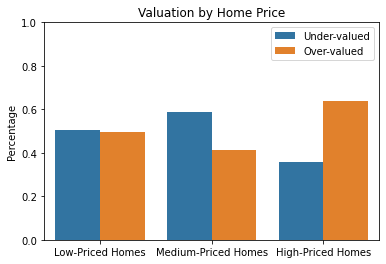

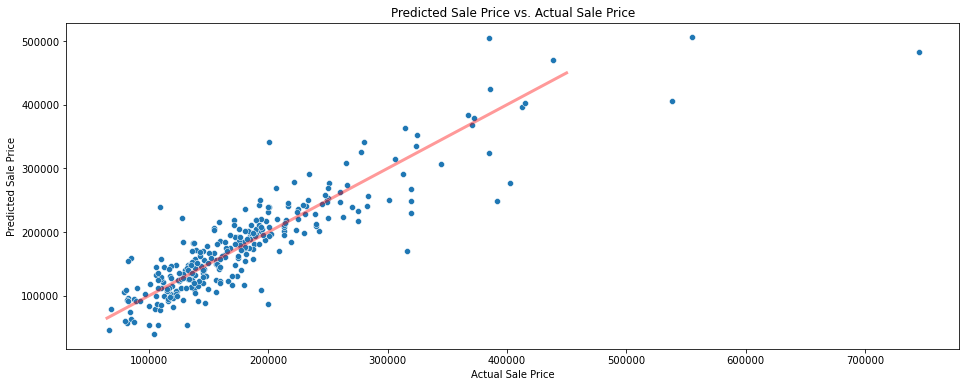

C:\Users\Carly\anaconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


  params  mean_test_neg_mean_squared_error  mean_test_neg_mean_absolute_error  \
0     {}                               NaN                                NaN   

   mean_test_r2  std_test_neg_mean_absolute_error  
0           NaN                               NaN  
Best linear model with polynomial features:
{}
       LotFrontage MasVnrArea 2ndFlrSF  MasVnrArea WoodDeckSF^2  \
coeff                      -369.717858              -350.913631   

       BsmtFinSF1 BedroomAbvGr MasVnrType_BrkFace  BsmtFinSF1 WoodDeckSF^2  \
coeff                                 -345.560099              -345.323006   

       BsmtFinSF1^2 BsmtExposure_No  2ndFlrSF BedroomAbvGr GarageCars  \
coeff                   -311.609217                       -302.627167   

       OverallCond EnclosedPorch Crime  BsmtFinSF1 GarageArea BsmtQual_Gd  \
coeff                      -300.980638                        -296.169541   

       BsmtFinSF1 BedroomAbvGr KitchenQual_Gd  \
coeff                             -280.7140

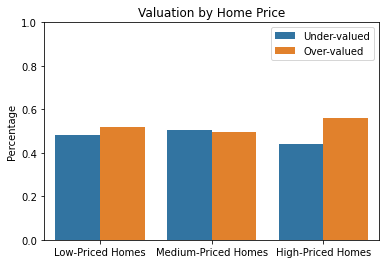

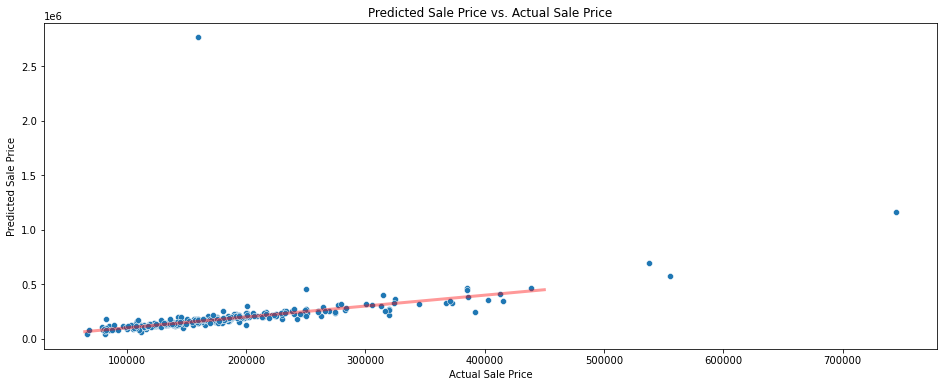

In [7]:
# Fit a linear model with polynomial features
models = [('poly2', PolynomialFeatures(include_bias=False, degree=2)),
          ('poly3', PolynomialFeatures(include_bias=False, degree=3))]

for model_name, model in models:
    params = {}
    ct = ColumnTransformer([
            ('scaler', StandardScaler(), cont_cols_trunc)
        ], remainder='passthrough')
    pipeline = Pipeline([
        ('norm', ct),
        (model_name, model),
        ('regr', linear_model.LinearRegression()),
    ])
    gs = GridSearchCV(estimator=pipeline, 
                      param_grid=params, 
                      cv=5,
                      scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                      refit='neg_mean_absolute_error',
                      n_jobs=-1)
    gs.fit(x_train_trunc, y_train)

    # Output results
    results = pd.DataFrame(gs.cv_results_)
    results = results.sort_values(by=['mean_test_neg_mean_squared_error'])
    print(results[['params', 'mean_test_neg_mean_squared_error', 'mean_test_neg_mean_absolute_error', 'mean_test_r2',
                   'std_test_neg_mean_absolute_error']])

    # Print coefficients
    coeffs = pd.DataFrame(data=np.reshape(gs.best_estimator_['regr'].coef_, (1,-1)),
                          columns=gs.best_estimator_[model_name].get_feature_names(x_train_trunc.columns), index=['coeff'] )
    print(coeffs.sort_values(by='coeff', axis=1))

    # Predict housing values for the test set using the best polynomial model
    y_test_hat = gs.predict(x_test_trunc)

    # Compute model evaluation metrics for the best polynomial model
    metrics_and_plots(y_test, y_test_hat)

                                        params  \
1       {'Lasso__alpha': 1, 'poly__degree': 2}   
0     {'Lasso__alpha': 0.1, 'poly__degree': 2}   
2       {'Lasso__alpha': 2, 'poly__degree': 2}   
3      {'Lasso__alpha': 10, 'poly__degree': 2}   
4     {'Lasso__alpha': 100, 'poly__degree': 2}   
13  {'Lasso__alpha': 10000, 'poly__degree': 2}   
5     {'Lasso__alpha': 477, 'poly__degree': 2}   
6     {'Lasso__alpha': 478, 'poly__degree': 2}   
7     {'Lasso__alpha': 479, 'poly__degree': 2}   
12   {'Lasso__alpha': 5000, 'poly__degree': 2}   
8     {'Lasso__alpha': 941, 'poly__degree': 2}   
9     {'Lasso__alpha': 942, 'poly__degree': 2}   
10    {'Lasso__alpha': 943, 'poly__degree': 2}   
11   {'Lasso__alpha': 1000, 'poly__degree': 2}   

    mean_test_neg_mean_squared_error  mean_test_neg_mean_absolute_error  \
1                      -3.073891e+09                      -25039.415404   
0                      -3.033505e+09                      -26763.255021   
2                      -

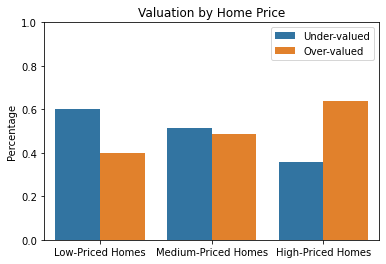

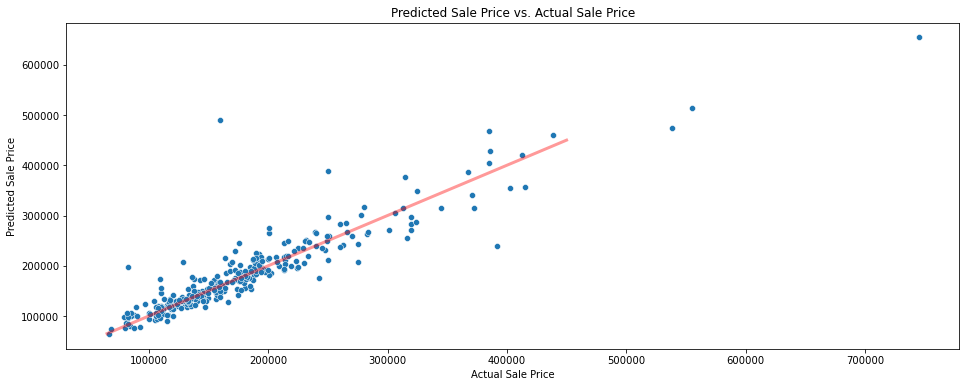

                                        params  \
0     {'Ridge__alpha': 0.1, 'poly__degree': 2}   
1       {'Ridge__alpha': 1, 'poly__degree': 2}   
2       {'Ridge__alpha': 2, 'poly__degree': 2}   
3      {'Ridge__alpha': 10, 'poly__degree': 2}   
13  {'Ridge__alpha': 10000, 'poly__degree': 2}   
12   {'Ridge__alpha': 5000, 'poly__degree': 2}   
4     {'Ridge__alpha': 100, 'poly__degree': 2}   
5     {'Ridge__alpha': 477, 'poly__degree': 2}   
6     {'Ridge__alpha': 478, 'poly__degree': 2}   
7     {'Ridge__alpha': 479, 'poly__degree': 2}   
11   {'Ridge__alpha': 1000, 'poly__degree': 2}   
10    {'Ridge__alpha': 943, 'poly__degree': 2}   
9     {'Ridge__alpha': 942, 'poly__degree': 2}   
8     {'Ridge__alpha': 941, 'poly__degree': 2}   

    mean_test_neg_mean_squared_error  mean_test_neg_mean_absolute_error  \
0                      -2.568432e+09                      -24588.713060   
1                      -2.346406e+09                      -23624.395743   
2                      -

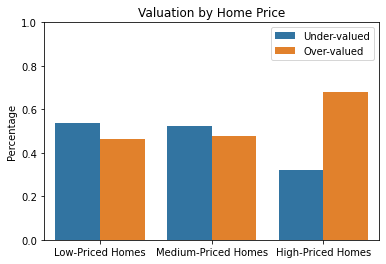

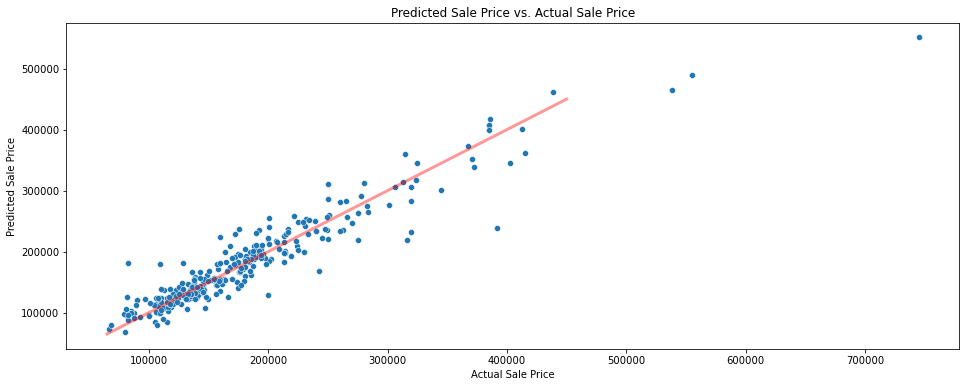

                                              params  \
13  {'Elastic Net__alpha': 10000, 'poly__degree': 2}   
12   {'Elastic Net__alpha': 5000, 'poly__degree': 2}   
11   {'Elastic Net__alpha': 1000, 'poly__degree': 2}   
10    {'Elastic Net__alpha': 943, 'poly__degree': 2}   
9     {'Elastic Net__alpha': 942, 'poly__degree': 2}   
8     {'Elastic Net__alpha': 941, 'poly__degree': 2}   
7     {'Elastic Net__alpha': 479, 'poly__degree': 2}   
6     {'Elastic Net__alpha': 478, 'poly__degree': 2}   
5     {'Elastic Net__alpha': 477, 'poly__degree': 2}   
4     {'Elastic Net__alpha': 100, 'poly__degree': 2}   
0     {'Elastic Net__alpha': 0.1, 'poly__degree': 2}   
3      {'Elastic Net__alpha': 10, 'poly__degree': 2}   
1       {'Elastic Net__alpha': 1, 'poly__degree': 2}   
2       {'Elastic Net__alpha': 2, 'poly__degree': 2}   

    mean_test_neg_mean_squared_error  mean_test_neg_mean_absolute_error  \
13                     -6.092654e+09                      -57206.096111   
12       

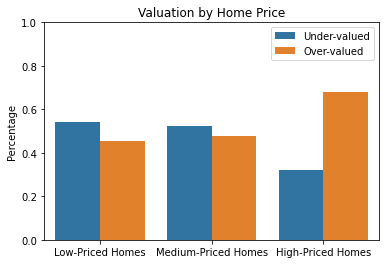

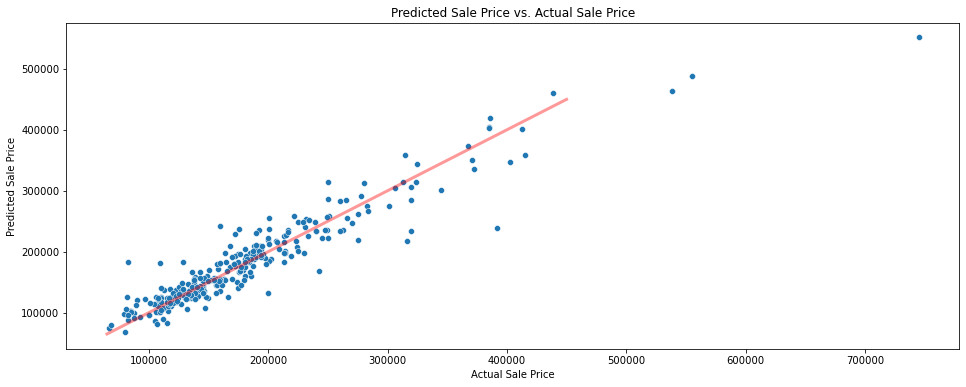

In [7]:
# Fit a regularized linear model with two-degree polynomial features
models = [('Lasso', linear_model.Lasso(max_iter=100000)),
           ('Ridge', linear_model.Ridge(max_iter=100000)),
           ('Elastic Net', linear_model.ElasticNet(max_iter=100000))]

for model_name, model in models:
    params = {model_name + '__alpha' : (0.1,1,2,10,100,477,478,479,941,942,943,1000,5000,10000)}
    ct = ColumnTransformer([
        ('scaler', StandardScaler(), cont_cols_trunc)
    ], remainder='passthrough')
    pipeline = Pipeline([
        ('norm', ct),
        ('poly', PolynomialFeatures(include_bias=False, degree=2)),
        (model_name, model)
    ])
    gs = GridSearchCV(estimator=pipeline, 
                      param_grid=params,
                      cv=5,
                      scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                      refit='neg_mean_absolute_error',
                      n_jobs=-1)
    gs.fit(x_train_trunc, y_train)
    
    # Output results
    results = pd.DataFrame(gs.cv_results_)
    results = results.sort_values(by=['mean_test_neg_mean_squared_error'])
    print(results[['params', 'mean_test_neg_mean_squared_error', 'mean_test_neg_mean_absolute_error', 'mean_test_r2',
                   'std_test_neg_mean_absolute_error']])
    
    # Output the alpha that gives the best fit for the model
    print("Best ", model_name, " model with polynomial features:")
    print(gs.best_params_)
    
    # Print coefficients
    coeffs = pd.DataFrame(data=np.reshape(gs.best_estimator_[model_name].coef_, (1,-1)),
                          columns=gs.best_estimator_['poly'].get_feature_names(x_train_trunc.columns), index=['coeff'] )
    print(coeffs.sort_values(by='coeff', axis=1))
    
    # Predict housing values for the test set using the best model
    y_test_hat = gs.predict(x_test_trunc)
    
    # Compute model evaluation metrics for the best model
    metrics_and_plots(y_test, y_test_hat)

In [ ]:
# Fit a regularized linear model with three-degree polynomial features.
# Note that the three-degree model takes an extremely long time to run due to the number of features.
# As a result, we performed the grid search on the CS servers, and we are
# only displaying the best-performing models here.

models = [('Lasso', linear_model.Lasso(max_iter=100000, alpha=595)),
           ('Ridge', linear_model.Ridge(max_iter=100000, alpha=3300)),
           ('Elastic Net', linear_model.ElasticNet(max_iter=100000, alpha=8))]

for model_name, model in models:
    params = {}
    ct = ColumnTransformer([
        ('scaler', StandardScaler(), cont_cols_trunc)
    ], remainder='passthrough')
    pipeline = Pipeline([
        ('norm', ct),
        ('poly', PolynomialFeatures(include_bias=False, degree=3)),
        (model_name, model)
    ])
    gs = GridSearchCV(estimator=pipeline, 
                      param_grid=params,
                      cv=5,
                      scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                      refit='neg_mean_absolute_error',
                      n_jobs=-1)
    gs.fit(x_train_trunc, y_train)
    
    # Output results
    results = pd.DataFrame(gs.cv_results_)
    results = results.sort_values(by=['mean_test_neg_mean_squared_error'])
    print(results[['params', 'mean_test_neg_mean_squared_error', 'mean_test_neg_mean_absolute_error', 'mean_test_r2',
                   'std_test_neg_mean_absolute_error']])
    
    # Print coefficients
    coeffs = pd.DataFrame(data=np.reshape(gs.best_estimator_[model_name].coef_, (1,-1)),
                          columns=gs.best_estimator_['poly'].get_feature_names(x_train_trunc.columns), index=['coeff'] )
    print(coeffs.sort_values(by='coeff', axis=1))
    
    # Predict housing values for the test set using the best model
    y_test_hat = gs.predict(x_test_trunc)
    
    # Compute model evaluation metrics for the best model
    metrics_and_plots(y_test, y_test_hat)

C:\Users\Carly\anaconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
